<a href="https://colab.research.google.com/github/julia-lina-tan/TSP/blob/master/bhmFusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/julia-lina-tan/Datasets.git
%cd Datasets

Cloning into 'Datasets'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 31 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.
/content/Datasets


#Bayesian Hilbert Maps

In [2]:
"""
# 2D and 3D Bayesian Hilbert Maps with pytorch
# Ransalu Senanayake
"""
import torch as pt
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
import pandas as pd

dtype = pt.float32
device = pt.device("cpu")
# device = pt.device("cuda:0") # Uncomment this to run on GPU

class BHM2D_PYTORCH():
    def __init__(self, gamma=0.05, grid=None, cell_resolution=(5, 5), cell_max_min=None, X=None, nIter=0, mu_sig=None):
        """
        :param gamma: RBF bandwidth
        :param grid: if there are prespecified locations to hinge the RBF
        :param cell_resolution: if 'grid' is 'None', resolution to hinge RBFs
        :param cell_max_min: if 'grid' is 'None', realm of the RBF field
        :param X: a sample of lidar locations to use when both 'grid' and 'cell_max_min' are 'None'
        """
        self.gamma = gamma
        if grid is not None:
            self.grid = grid
        else:
            self.grid = self.__calc_grid_auto(cell_resolution, cell_max_min, X)
        self.nIter = nIter
        print(' Number of hinge points={}'.format(self.grid.shape[0]))

        #ADDED
        if mu_sig is not None:
            self.mu = pt.tensor(mu_sig[:,0], dtype=pt.float32)
            self.sig = pt.tensor(mu_sig[:,1], dtype=pt.float32)

    def updateGrid(grid):
        self.grid = grid

    def updateMuSig(mu_sig):
        self.mu = pt.tensor(mu_sig[:,0], dtype=pt.float32)
        self.sig = pt.tensor(mu_sig[:,1], dtype=pt.float32)

    def __calc_grid_auto(self, cell_resolution, max_min, X):
        """
        :param X: a sample of lidar locations
        :param cell_resolution: resolution to hinge RBFs as (x_resolution, y_resolution)
        :param max_min: realm of the RBF field as (x_min, x_max, y_min, y_max)
        :return: numpy array of size (# of RNFs, 2) with grid locations
        """
        # X = X.numpy()

        if max_min is None:
            # if 'max_min' is not given, make a boundarary based on X
            # assume 'X' contains samples from the entire area
            expansion_coef = 1.2
            x_min, x_max = expansion_coef*X[:, 0].min(), expansion_coef*X[:, 0].max()
            y_min, y_max = expansion_coef*X[:, 1].min(), expansion_coef*X[:, 1].max()
        else:
            x_min, x_max = max_min[0], max_min[1]
            y_min, y_max = max_min[2], max_min[3]

        xx, yy = np.meshgrid(np.arange(x_min, x_max, cell_resolution[0]), \
                             np.arange(y_min, y_max, cell_resolution[1]))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))

        return pt.tensor(grid)

    def __sparse_features(self, X):
        """
        :param X: inputs of size (N,2)
        :return: hinged features with intercept of size (N, # of features + 1)
        """
        rbf_features = rbf_kernel(X, self.grid, gamma=self.gamma)
        # COMMENTED OUT BIAS TERM
        # rbf_features = np.hstack((np.ones(X.shape[0])[:, np.newaxis], rbf_features))
        return pt.tensor(rbf_features, dtype=pt.float32)

    def __calc_posterior(self, X, y, epsilon, mu0, sig0):
        """
        :param X: input features
        :param y: labels
        :param epsilon: per dimension local linear parameter
        :param mu0: mean
        :param sig0: variance
        :return: new_mean, new_varaiance
        """
        logit_inv = pt.sigmoid(epsilon)
        lam = 0.5 / epsilon * (logit_inv - 0.5)
        sig = 1/(1/sig0 + 2*pt.sum( (X.t()**2)*lam, dim=1))
        mu = sig*(mu0/sig0 + pt.mm(X.t(), y - 0.5).squeeze())
        return mu, sig

    def fit(self, X, y):
        """
        :param X: raw data
        :param y: labels
        """
        X = self.__sparse_features(X)
        N, D = X.shape[0], X.shape[1]

        self.epsilon = pt.ones(N, dtype=pt.float32)
        if not hasattr(self, 'mu'):
            self.mu = pt.zeros(D, dtype=pt.float32)
            self.sig = 10000 * pt.ones(D, dtype=pt.float32)

        for i in range(self.nIter):
            print("  Parameter estimation: iter={}".format(i))

            # E-step
            self.mu, self.sig = self.__calc_posterior(X, y, self.epsilon, self.mu, self.sig)

            # M-step
            self.epsilon = pt.sqrt(pt.sum((X**2)*self.sig, dim=1) + (X.mm(self.mu.reshape(-1, 1))**2).squeeze())

        # print(self.mu)

        return self.mu, self.sig


    def predict(self, Xq):
        """
        :param Xq: raw inquery points
        :return: mean occupancy (Laplace approximation)
        """
        Xq = self.__sparse_features(Xq)

        mu_a = Xq.mm(self.mu.reshape(-1, 1)).squeeze()
        sig2_inv_a = pt.sum((Xq ** 2) * self.sig, dim=1)
        k = 1.0 / pt.sqrt(1 + np.pi * sig2_inv_a / 8)

        return pt.sigmoid(k*mu_a)

    def predictSampling(self, Xq, nSamples=50):
        """
        :param Xq: raw inquery points
        :param nSamples: number of samples to take the average over
        :return: sample mean and standard deviation of occupancy
        """
        Xq = self.__sparse_features(Xq)

        qw = pt.distributions.MultivariateNormal(self.mu, pt.diag(self.sig))
        w = qw.sample((nSamples,)).t()

        mu_a = Xq.mm(w).squeeze()
        probs = pt.sigmoid(mu_a)

        mean = pt.mean(probs, dim=1).squeeze()
        std = pt.std(probs, dim=1).squeeze()

        return mean, std

# Train BHM Model

In [3]:
import os
import time
import numpy as np
import pandas as pd
import torch as pt
import matplotlib.pyplot as pl
#from bhmtorch_cpu import BHM2D_PYTORCH

def getPartitions(cell_max_min, nPartx1, nPartx2):
    """
    :param cell_max_min: The size of the entire area
    :param nPartx1: How many partitions along the longitude
    :param nPartx2: How many partitions along the latitude
    :return: a list of all partitions
    """
    width = cell_max_min[1] - cell_max_min[0]
    height = cell_max_min[3] - cell_max_min[2]
    cell_max_min_segs = []
    for x in range(nPartx1):
        for y in range(nPartx2):
            seg_i = (cell_max_min[0] + width / nPartx1 * x, cell_max_min[0] + width / nPartx1 * (x + 1), \
                     cell_max_min[2] + height / nPartx2 * y, cell_max_min[2] + height / nPartx2 * (y + 1))
            cell_max_min_segs.append(seg_i)

    return cell_max_min_segs

def load_parameters(case):
    filename = case
    parameters = \
        {filename: \
             ( os.path.abspath('../../Datasets/simulated/'+filename),
              (3, 3), #hinge point resolution
              (-100, 100, 0, 100), #area [x1_min, x1_max, x2_min, x2_max] 
              None,
              None,
              0.5, #gamma
              ),

         }

    return parameters[case]

def trainModel(filename):

    # Read the file
    fn_train, cell_resolution, cell_max_min, _, _, gamma = load_parameters(filename)
    fn_train = fn_train[1:]

    # Partition the environment into to 4 areas
    # TODO: We can parallelize this
    cell_max_min_segments = getPartitions(cell_max_min, 1, 1) #NOTE: this is implemented to segment the environment and do mapping speperately. For now, let's consider that there's only one segment.

    # Read data
    print('\nReading '+fn_train+'.csv...')
    g = pd.read_csv(fn_train+'.csv', delimiter=', ').values[:, :]

    # Filter data
    layer = g[:,0] <= 100 #NOTE: let's consider time frames < 100
    g = pt.tensor(g[layer, :], dtype=pt.float32)
    X = g[:, 1:3] 
    y = g[:, 3].reshape(-1, 1)
    # if pt.cuda.is_available():
    #     X = X.cuda()
    #     y = y.cuda()

    toPlot = []
    totalTime = 0
    hingePoints = None

    for segi in range(len(cell_max_min_segments)):
        print(' Mapping segment {} of {}...'.format(segi+1,len(cell_max_min_segments)))
        cell_max_min = cell_max_min_segments[segi]

        bhm_mdl = BHM2D_PYTORCH(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X, nIter=1)

        t1 = time.time()
        bhm_mdl.fit(X, y)
        t2 = time.time()
        totalTime += (t2-t1)

        # Append mean and variance of weights to hinge points matrix
        hingePoints = np.column_stack((bhm_mdl.grid, bhm_mdl.mu, bhm_mdl.sig))

        # Query the model
        q_resolution = 1
        xx, yy= np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1] - 1, q_resolution),
                            np.arange(cell_max_min[2], cell_max_min[3] - 1, q_resolution))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
        Xq = pt.tensor(grid, dtype=pt.float32)
        yq = bhm_mdl.predict(Xq)
        toPlot.append((Xq,yq))

    print(' Total training time={} s'.format(np.round(totalTime, 2))) 
    plotOccupancy(hingePoints, X, y, cell_max_min, cell_max_min_segments, gamma, toPlot, title=filename)
    return hingePoints

def plotOccupancy(hingePoints, X, y, cell_max_min, cell_max_min_segments, gamma, toPlot, title=None):
    pl.close('all')
    pl.rcParams['figure.facecolor'] = 'white'
    pl.figure(figsize=(30,15))
    pl.suptitle(title + ': {} hinge points, gamma = {}'.format(hingePoints.shape[0], gamma))

    # Scatter plot raw data
    pl.subplot(221)
    pl.title('Raw lidar data')
    pl.scatter(X[:,0], X[:,1], c=y, s=5, cmap='jet')
    pl.xlim([cell_max_min[0], cell_max_min[1]]); pl.ylim([cell_max_min[2], cell_max_min[3]])
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot occupancy map
    pl.subplot(222)
    pl.title('Occupancy map')
    for segi in range(len(cell_max_min_segments)):
        ploti = toPlot[segi]
        Xq, yq = ploti[0], ploti[1]
        pl.scatter(Xq[:, 0], Xq[:, 1], c=yq, cmap='jet', s=5, vmin=0, vmax=1)
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot mean of weights at hinge points
    pl.subplot(223)
    pl.title('Mean at hinge points')
    pl.scatter(hingePoints[:,0], hingePoints[:,1], c=hingePoints[:,2], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot variance of weights at hinge points
    pl.subplot(224)
    pl.title('Variance at hinge points')
    pl.scatter(hingePoints[:,0], hingePoints[:,1], c=hingePoints[:,3], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    #pl.savefig(os.path.abspath('../../Outputs/'+filename+'.png'))
    pl.show()


# Settings
dtype = pt.float32
device = pt.device("cpu")
# device = pt.device("cuda:0") # Uncomment this to run on GPU


In [ ]:
# Get the filename to read data points from
filename = input("Input file: ")
result = trainModel(filename)

#Fusion: N Sources

     |████████████████████████████████| 430kB 7.2MB/s 
Number of files: 4
Input file 1: static_test5
Input file 2: static_test6
Input file 3: static_test7
Input file 4: static_test8

Reading Datasets/simulated/static_test5.csv...
 Mapping segment 1 of 1...
 Number of hinge points=2278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


  Parameter estimation: iter=0
 Total training time=2.43 s


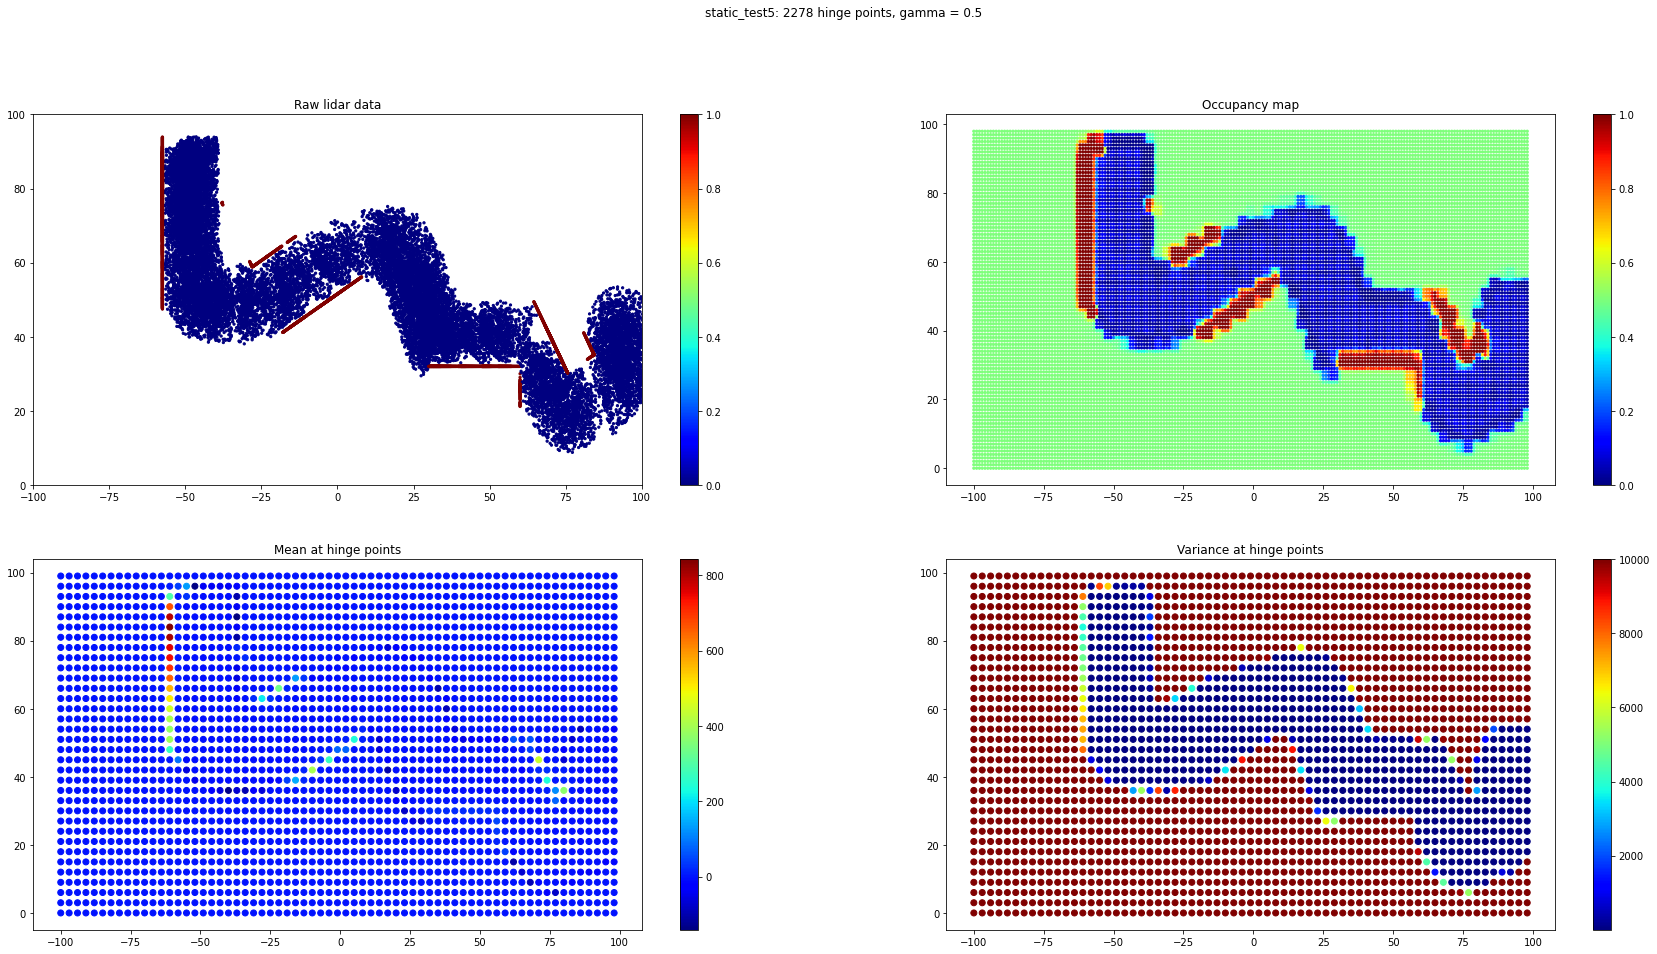


Reading Datasets/simulated/static_test6.csv...
 Mapping segment 1 of 1...
 Number of hinge points=2278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


  Parameter estimation: iter=0
 Total training time=2.49 s


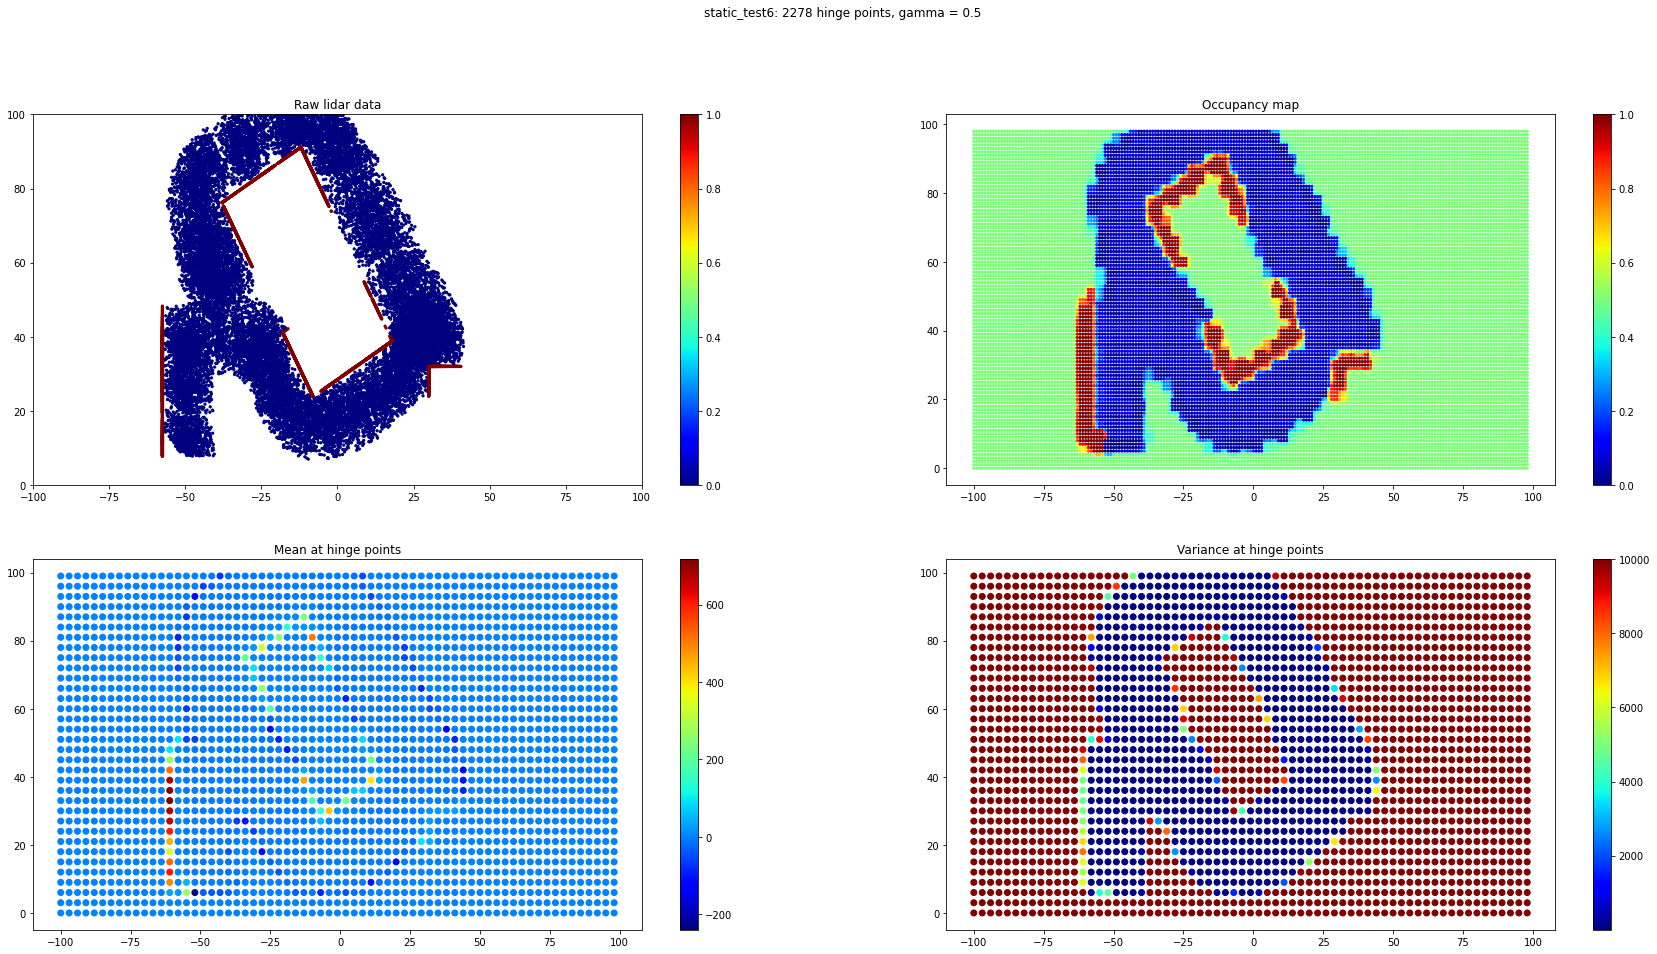


Reading Datasets/simulated/static_test7.csv...
 Mapping segment 1 of 1...
 Number of hinge points=2278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


  Parameter estimation: iter=0
 Total training time=3.13 s


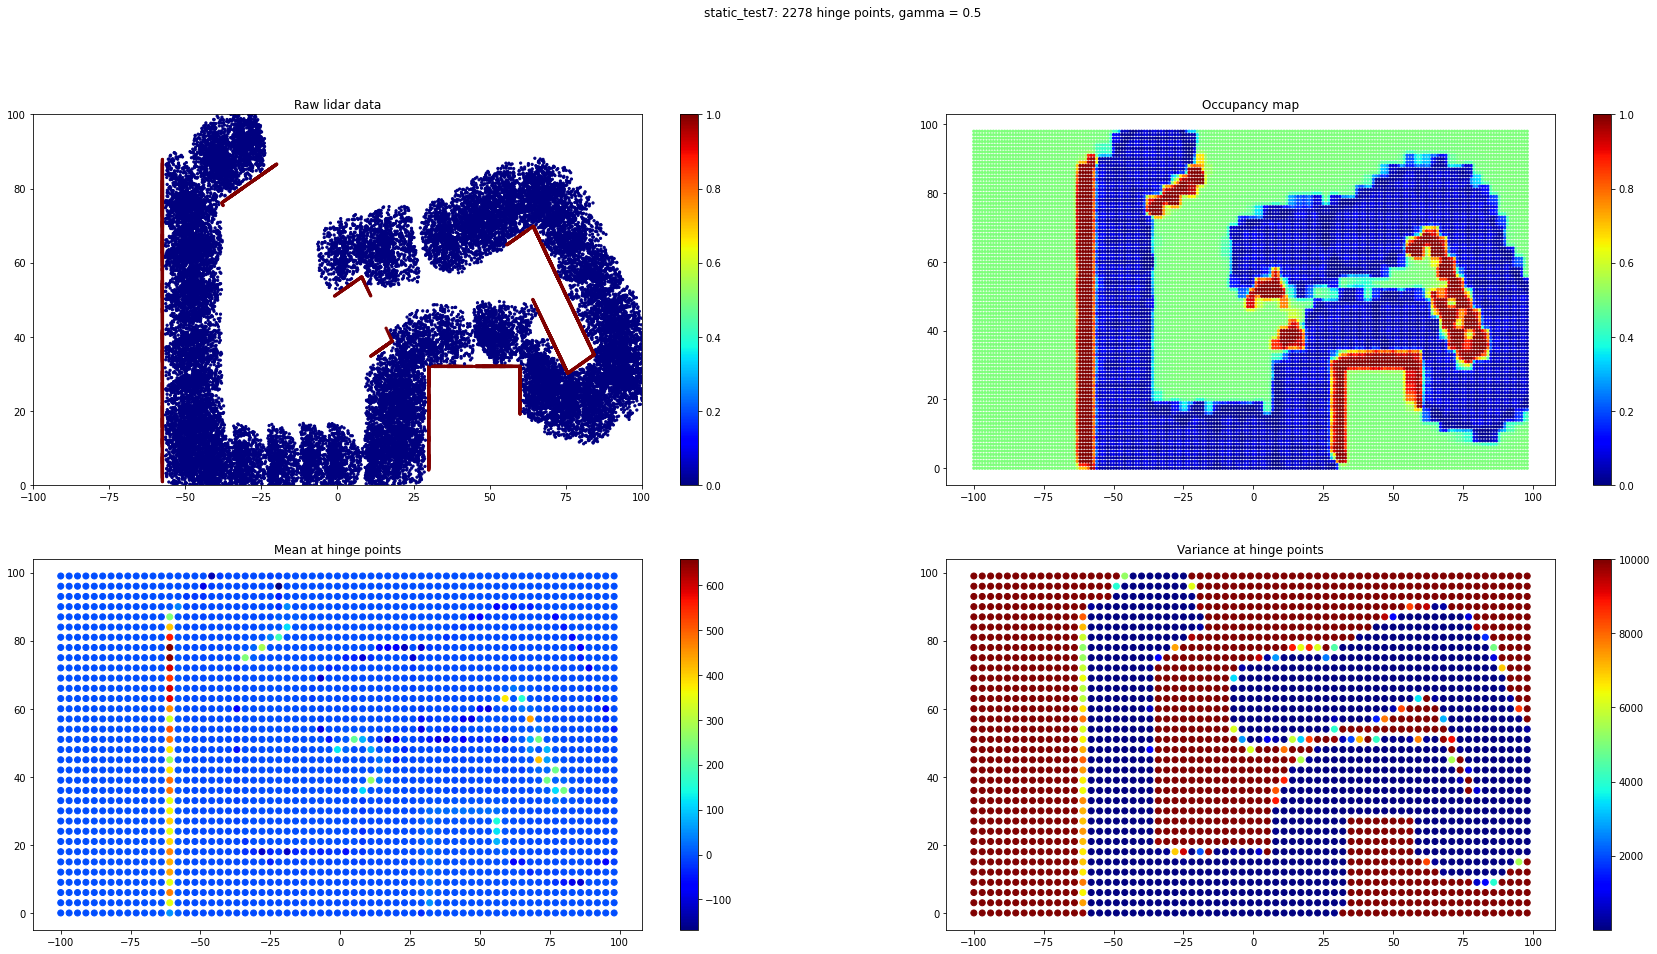


Reading Datasets/simulated/static_test8.csv...
 Mapping segment 1 of 1...
 Number of hinge points=2278


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


  Parameter estimation: iter=0
 Total training time=1.58 s


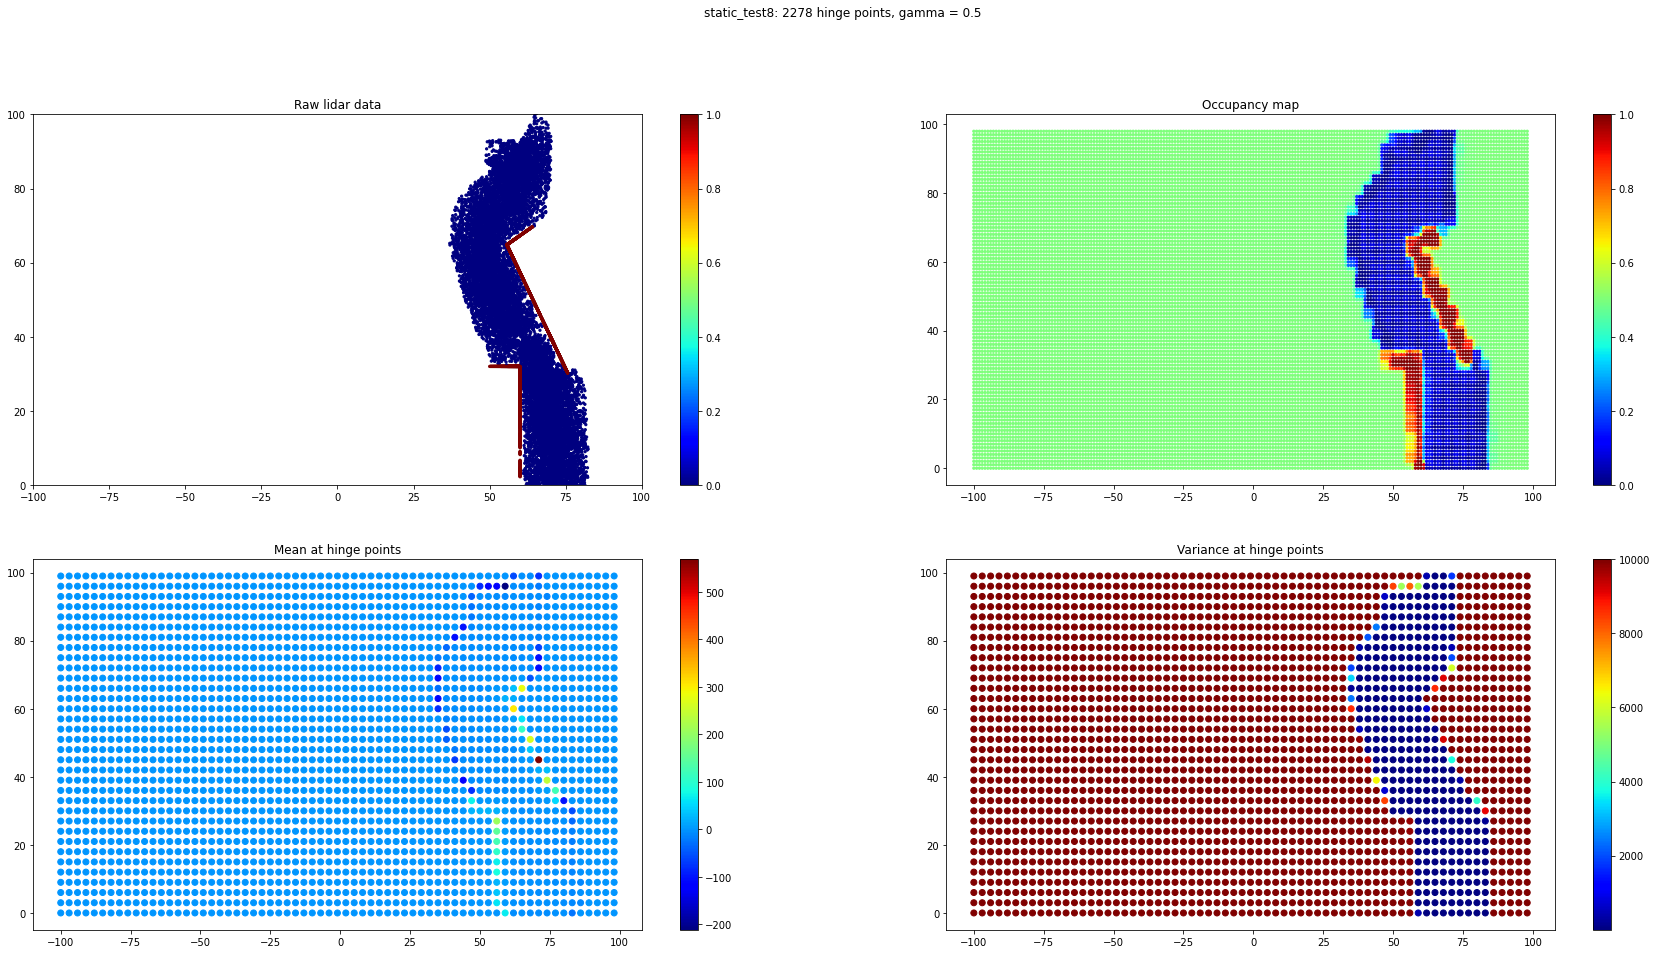

In [4]:
!pip install pot
!pip install tqdm
import ot
import scipy
from tqdm import tqdm

# Get the filenames of the sources to read data points from
nFiles = int(input("Number of files: "))
files = []
for i in range(nFiles):
    f = input(f"Input file {i+1}: ")
    files.append(f)

# Train each model separately
nWeights = []
for i in range(len(files)):
    filename = files[i]
    weights_i = trainModel(filename)
    nWeights.append(weights_i)

# Assume parameters are the same across all models
fn_train, cell_resolution, cell_max_min, _, _, gamma = load_parameters(files[0])


##Ground Truth

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


 Mapping segment 1 of 1...
 Number of hinge points=2278
  Parameter estimation: iter=0
 Total training time=9.95 s


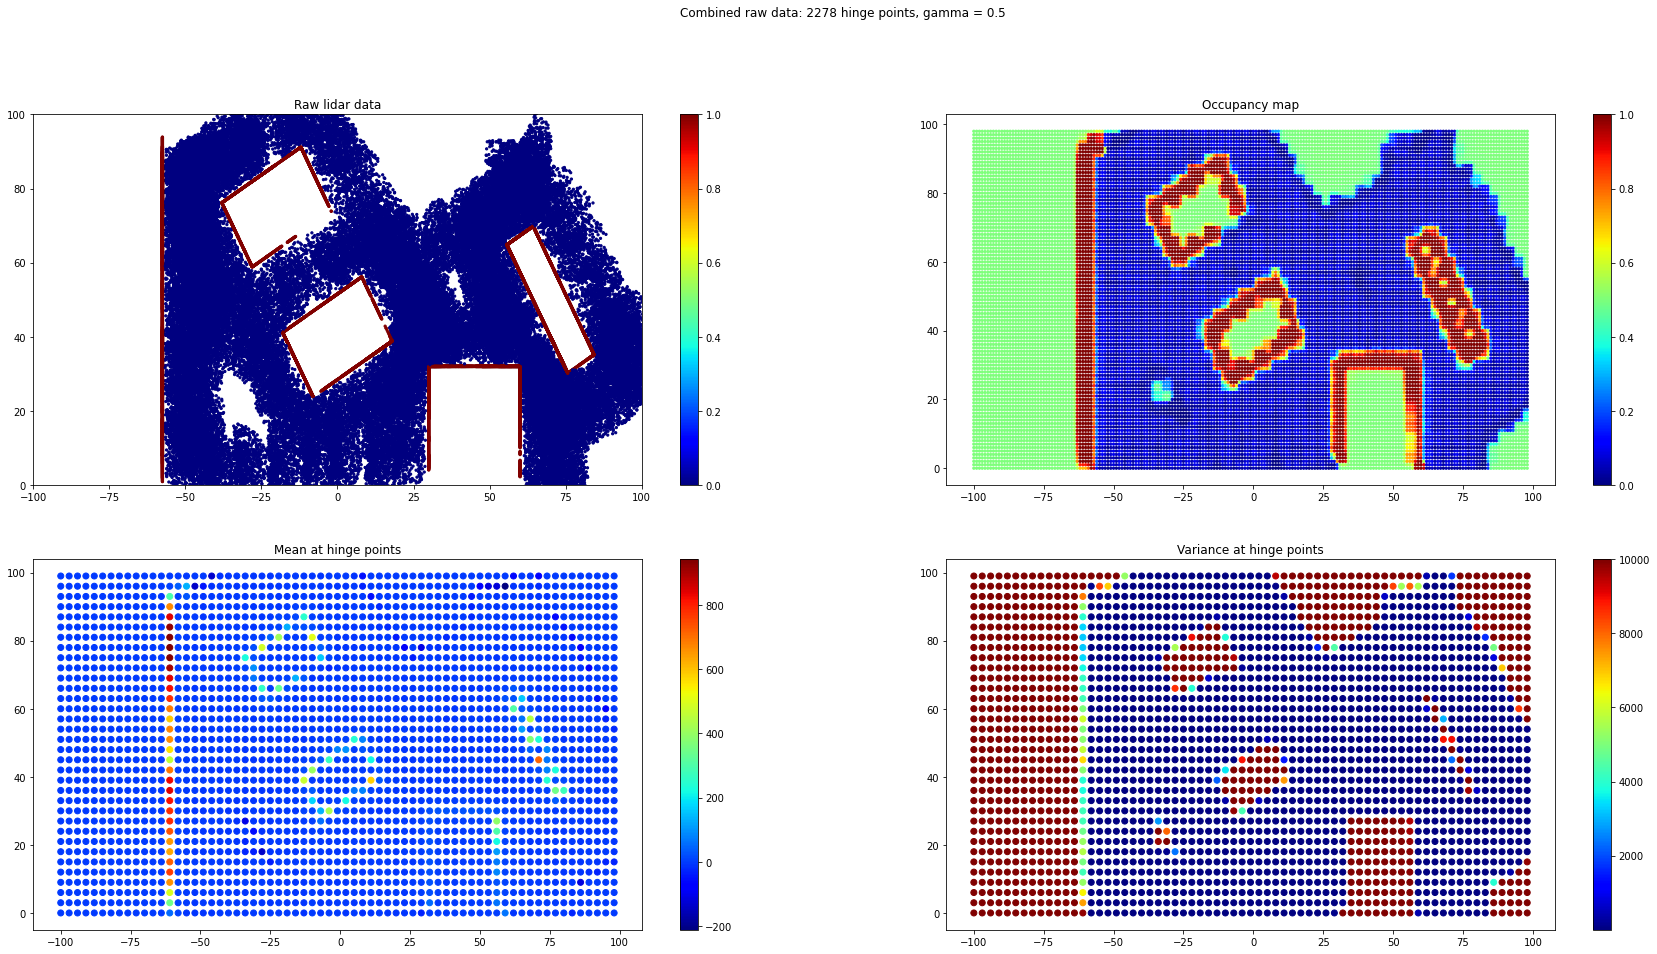

In [5]:
# Combine all raw lidar data 
def combineRawData(files):

    list_X = []
    list_y = []
    
    # Assume parameters are the same across all datasets
    cell_max_min = None
    cell_resolution = None
    gamma = None

    # Read each file separately
    for i in range(len(files)):
        filename = files[i]
        fn_train, cell_resolution, cell_max_min, _, _, gamma = load_parameters(filename)
        fn_train = fn_train[1:]
        cell_max_min_segments = getPartitions(cell_max_min, 1, 1)
        g = pd.read_csv(fn_train+'.csv', delimiter=', ').values[:, :]

        # Filter data
        layer = g[:,0] <= 100
        g = pt.tensor(g[layer, :], dtype=pt.float32)
        X = g[:, 1:3]
        y = g[:, 3].reshape(-1, 1)

        # Append data to list 
        list_X.append(X)
        list_y.append(y)

    # Convert lists into tensors
    all_X = pt.cat(list_X, dim=0)
    all_y = pt.cat(list_y, dim=0)

    # Map segments
    toPlot = []
    totalTime = 0
    hingePoints = None

    for segi in range(len(cell_max_min_segments)):
        print(' Mapping segment {} of {}...'.format(segi+1,len(cell_max_min_segments)))
        cell_max_min = cell_max_min_segments[segi]

        bhm_mdl = BHM2D_PYTORCH(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=all_X, nIter=1)

        t1 = time.time()
        bhm_mdl.fit(all_X, all_y)
        t2 = time.time()
        totalTime += (t2-t1)

        # Append mean and variance of weights to hinge points matrix
        hingePoints = np.column_stack((bhm_mdl.grid, bhm_mdl.mu, bhm_mdl.sig))

        # Query the model
        q_resolution = 1
        xx, yy= np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1] - 1, q_resolution),
                            np.arange(cell_max_min[2], cell_max_min[3] - 1, q_resolution))
        grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
        Xq = pt.tensor(grid, dtype=pt.float32)
        yq = bhm_mdl.predict(Xq)
        toPlot.append((Xq,yq))

    print(' Total training time={} s'.format(np.round(totalTime, 2))) 
    plotOccupancy(hingePoints, all_X, all_y, cell_max_min, cell_max_min_segments, gamma, toPlot, title='Combined raw data')

    # Concatenate tensors to make ground truth tensor with columns xyocc
    gt_tensor = pt.cat((all_X, all_y), dim=1)

    # Extract xyocc values from ground truth tensor and convert to numpy matrix
    gt_x = gt_tensor[:,0].numpy()
    gt_y = gt_tensor[:,1].numpy()
    gt_occ = gt_tensor[:,2].numpy()
    gt_matrix = np.column_stack((gt_x, gt_y, gt_occ))

    # Remove points that are not within the cell max/min bounds
    ground_truth = []
    for i in range(len(gt_matrix)):
        if gt_matrix[i][0] > cell_max_min[0] and gt_matrix[i][0] < cell_max_min[1]-1 and gt_matrix[i][1] > cell_max_min[2] and gt_matrix[i][1] < cell_max_min[3]-1:
            ground_truth.append(gt_matrix[i, :])

    ground_truth = np.stack(ground_truth, axis=0)
    return ground_truth

ground_truth = combineRawData(files);


##Naive Methods

100%|██████████| 2278/2278 [00:00<00:00, 66549.82it/s]


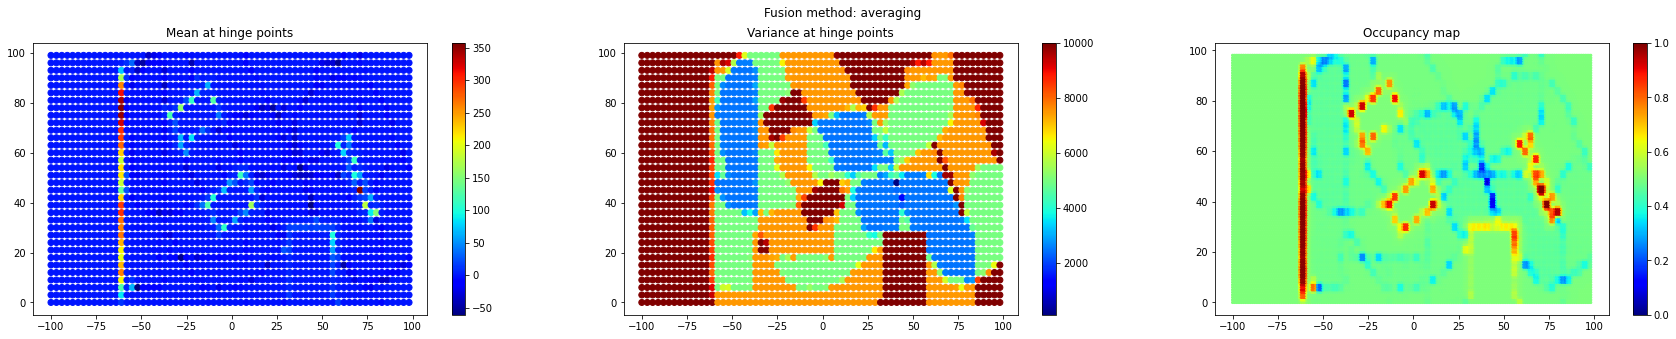

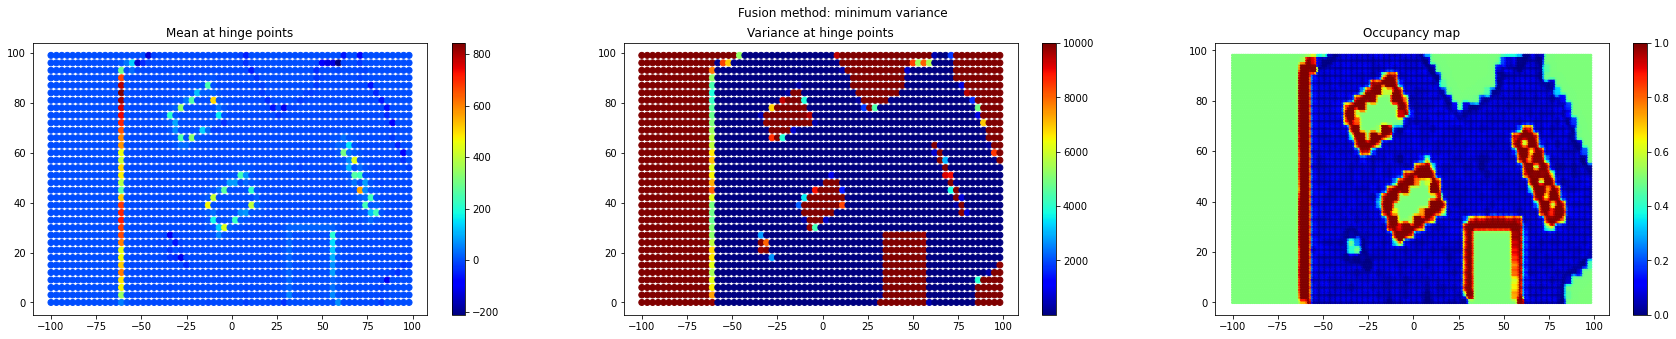

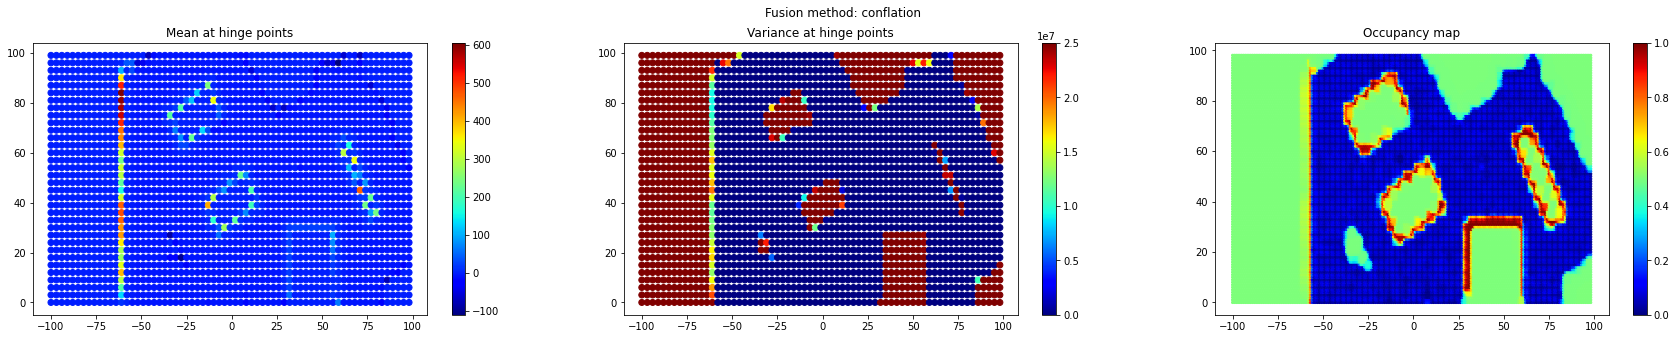

In [7]:
def fusionAverages(nWeights):

    # Initialise arrays to store averaged data
    aveMean = []
    aveVar = []    
    
    # Loop through each hinge point
    for i in tqdm(range(nWeights[0].shape[0])):

        # Get the average mean and variance 
        sumMean = 0
        sumVar = 0
        for j in range(len(nWeights)):
            sumMean += nWeights[j][i][2]
            sumVar += nWeights[j][i][3]

        aveMean.append(sumMean/len(nWeights))
        aveVar.append(sumVar/len(nWeights))
        
    # Add average mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], aveMean, aveVar))

    return fused

def fusionMinVar(nWeights):

    # Initialise arrays to store data
    mean = []
    var = []    
    
    # Loop through each hinge point
    for i in tqdm(range(nWeights[0].shape[0])):

        # Find the distribution with minimum variance
        minVar = nWeights[0][i][3]
        distribution = 0
        for j in range(len(nWeights)):
            currentVar = nWeights[j][i][3]
            if currentVar < minVar:
              minVar = currentVar
              distribution = j

        # Use the data from the distribution with minimum variance
        mean.append(nWeights[distribution][i][2])
        var.append(nWeights[distribution][i][3])
        
    # Add average mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], mean, var))

    return fused

def fusionConflation(nWeights):

    # Initialise arrays to store data
    mean = []
    var = []    
    
    # Loop through each hinge point
    for i in tqdm(range(nWeights[0].shape[0])):

        # Compute the new mean and variance
        mean_numerator = 0
        mean_denominator = 0
        var_denominator = 0
        for j in range(len(nWeights)):
            currentMean = nWeights[j][i][2]
            currentVar = nWeights[j][i][3]
            mean_numerator += currentMean/(currentVar**2)
            mean_denominator += 1/(currentVar**2)
            var_denominator += 1/(currentVar**2)
        
        # Store the new mean and variance values
        mean.append(mean_numerator/mean_denominator)
        var.append(1/var_denominator)
        
    # Add mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], mean, var))

    return fused

def queryFused(fused, cell_max_min=None):

    # Get max/min bounds of the area
    min_x = np.amin(fused[:,0])
    max_x = np.amax(fused[:,0])
    min_y = np.amin(fused[:,1])
    max_y = np.amax(fused[:,1])

    # Query the model
    q_resolution = 1
    xx, yy= np.meshgrid(np.arange(cell_max_min[0], cell_max_min[1] - 1, q_resolution),
                        np.arange(cell_max_min[2], cell_max_min[3] - 1, q_resolution))
    grid = np.hstack((xx.ravel()[:, np.newaxis], yy.ravel()[:, np.newaxis]))
    Xq = pt.tensor(grid, dtype=pt.float32)

    # Get sparse features 
    grid = np.column_stack((fused[:,0], fused[:,1]))
    rbf_features = rbf_kernel(Xq, grid, gamma=0.5)
    sparse_Xq = pt.tensor(rbf_features, dtype=pt.float32)

    # Get mean occupancy
    mu = pt.tensor(fused[:,2], dtype=pt.float32)
    sig = pt.tensor(fused[:,3], dtype=pt.float32)
    mu_a = sparse_Xq.mm(mu.reshape(-1, 1)).squeeze()
    sig2_inv_a = pt.sum((sparse_Xq ** 2) * sig, dim=1)
    k = 1.0 / pt.sqrt(1 + np.pi * sig2_inv_a / 8)
    yq = pt.sigmoid(k*mu_a)

    toPlot = np.column_stack((Xq, yq))
    return toPlot

def plotFused(toPlot, fused, fusionType=None):

    # Scatter plot mean of weights at hinge points
    pl.figure(figsize=(30,5))
    pl.suptitle('Fusion method: '+fusionType)

    pl.subplot(131)
    pl.title('Mean at hinge points')
    pl.scatter(fused[:,0], fused[:,1], c=fused[:,2], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

    # Scatter plot variance of weights at hinge points
    pl.subplot(132)
    pl.title('Variance at hinge points')
    pl.scatter(fused[:,0], fused[:,1], c=fused[:,3], cmap='jet')
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box') 

    # Scatter plot occupancy map
    pl.subplot(133)
    pl.title('Occupancy map')
    pl.scatter(toPlot[:, 0], toPlot[:, 1], c=toPlot[:, 2], cmap='jet', s=5, vmin=0, vmax=1)
    pl.colorbar()
    pl.gca().set_aspect('auto', adjustable='box')

# Fuse models using averages
fusedAverages = fusionAverages(nWeights)
plotAve = queryFused(fusedAverages, cell_max_min=cell_max_min)
plotFused(plotAve, fusedAverages, "averaging")

# Fuse models using minimum variance
fusedMinVar = fusionMinVar(nWeights)
plotMinVar = queryFused(fusedMinVar, cell_max_min=cell_max_min)
plotFused(plotMinVar, fusedMinVar, "minimum variance")

# Fuse models using conflation
fusedConflated = fusionConflation(nWeights)
plotConflated = queryFused(fusedConflated, cell_max_min=cell_max_min)
plotFused(plotConflated, fusedConflated, "conflation")


##Optimal Transport

In [8]:
def computeWeights(diff_entropy):
  
    # Map differential entropy to weights
    diff_entropy = np.array(diff_entropy)
    reciprocal = 1/np.absolute(diff_entropy)

    # Normalise the array 
    weights = reciprocal/np.sum(reciprocal)

    return weights

# Fuse models using OT
def fusionOT(nWeights):

    # Initialise arrays to store data
    bary_mean = []
    bary_var = []
  
    # Loop through each hinge point
    for i in tqdm(range(nWeights[0].shape[0])):
        nSamples = 5000
        measures_locations = []
        measures_weights = []
        diff_entropy = [];

        # Get each distribution
        for j in range(len(nWeights)):            
            mean = nWeights[j][i][2]
            var = nWeights[j][i][3]
            
            # Get evenly weighted samples from current distribution
            std = np.sqrt(var)
            x_i = np.random.normal(loc=mean, scale=std, size=nSamples).reshape(-1,1)
            b_i = np.ones(nSamples)/nSamples

            # Compute differential entropy of gaussian distribution
            h_x = np.log(var*np.sqrt(2*np.pi)) + 0.5;

            # Append current distribution to lists
            measures_locations.append(x_i)
            measures_weights.append(b_i)
            diff_entropy.append(h_x)

        # Compute barycenter coefficients from differential entropy
        bary_coef = computeWeights(diff_entropy)

        # Compute free support barycenter from random initial Dirac locations
        X_init = np.random.normal(0., 1., (len(bary_coef), 1))            
        X = ot.lp.free_support_barycenter(measures_locations, measures_weights, X_init, weights=bary_coef)

        # Get the mean and variance of the barycenter
        bary_mean.append(np.mean(X))
        bary_var.append(np.var(X))

    # Add mean and variance columns to matrix
    fused = np.column_stack((nWeights[0][:,0], nWeights[0][:,1], bary_mean, bary_var))

    return fused
        
fusedOT = fusionOT(nWeights)
plotOT = queryFused(fusedOT, cell_max_min=cell_max_min)
plotFused(plotOT, fusedOT, "1D wasserstein barycenter")

#K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import KFold
import csv
import sys
import scipy as sp
from sklearn import metrics

def occ_at_xy(x, y, xyocc_matrix=None):

    # Loop through each point in the matrix
    for i in range(len(xyocc_matrix)):

        # Check if the point is the given xy location
        if xyocc_matrix[i][0] == x and xyocc_matrix[i][1] == y:
            return xyocc_matrix[i][2]

def filter_predicted(ground_truth, averaging_predicted, min_var_predicted, conflation_predicted, ot_predicted):

    print("\nFiltering points...")
    
    compare_averaging = []
    compare_min_var = []
    compare_conflation = []
    compare_ot = []

   # Get only the points that are defined in the ground truth matrix
    for i in tqdm(range(len(ground_truth))):
        x = np.floor(ground_truth[i][0])
        y = np.floor(ground_truth[i][1])

        compare_averaging.append(occ_at_xy(x, y, xyocc_matrix=averaging_predicted))
        compare_min_var.append(occ_at_xy(x, y, xyocc_matrix=min_var_predicted))
        compare_conflation.append(occ_at_xy(x, y, xyocc_matrix=conflation_predicted))
        compare_ot.append(occ_at_xy(x, y, xyocc_matrix=ot_predicted))
    
    return compare_averaging, compare_min_var, compare_conflation, compare_ot

def calc_scores(mdl_name, true, predicted, N_points=0, do_return = False, save_report=True):
   fn = 'output/reports/'+ mdl_name + '.csv'

   predicted_binarized = np.int_(predicted >= 0.5)
   accuracy = np.round(metrics.accuracy_score(true.ravel(), predicted_binarized.ravel()), 3)

   auc = np.round(metrics.roc_auc_score(true.ravel(), predicted.ravel()), 3)

   nll = np.round(metrics.log_loss(true.ravel(), predicted.ravel()), 3)

   print(mdl_name+': accuracy={}, auc={}, nll={}'.format(accuracy, auc, nll))
   print(metrics.confusion_matrix(true.ravel(), predicted_binarized.ravel()))

  #  if save_report is True:
  #      with open(fn,'ab') as f_handle: #try 'a'
  #         np.savetxt(f_handle, np.array([[accuracy, auc, nll, N_points]]), delimiter=',', fmt="%.3f")

   if do_return:
       return accuracy, auc, nll

def train_fold(cell_max_min, cell_max_min_segments, cell_resolution, gamma=None, all_X_train=None, all_y_train=None, fold=None):

    # Get weights of each model (before fusion)
    n_weights = []

    # Train each model separately 
    for robot in range(len(all_X_train)):

        # Get training data
        X_train = all_X_train[robot][fold]
        y_train = all_y_train[robot][fold]

        for segi in range(len(cell_max_min_segments)):
            print(' Mapping segment {} of {}...'.format(segi+1,len(cell_max_min_segments)))
            cell_max_min = cell_max_min_segments[segi]

            bhm_mdl = BHM2D_PYTORCH(gamma=gamma, grid=None, cell_resolution=cell_resolution, cell_max_min=cell_max_min, X=X_train, nIter=1)
            bhm_mdl.fit(X_train, y_train)

            # Append mean and variance of hinge points to all weights list
            n_weights.append(np.column_stack((bhm_mdl.grid, bhm_mdl.mu, bhm_mdl.sig)))

    # Fuse models using averaging
    averaging_kernels = fusionAverages(n_weights)
    averaging_predicted = queryFused(averaging_kernels, cell_max_min=cell_max_min)

    # Fuse models using minimum variance
    min_var_kernels = fusionMinVar(n_weights)
    min_var_predicted = queryFused(min_var_kernels, cell_max_min=cell_max_min)

    # Fuse models using conflation
    conflation_kernels = fusionConflation(n_weights)
    conflation_predicted = queryFused(conflation_kernels, cell_max_min=cell_max_min)

    # Fuse models using OT
    ot_kernels = fusionOT(n_weights)
    ot_predicted = queryFused(ot_kernels, cell_max_min=cell_max_min)

    return averaging_predicted, min_var_predicted, conflation_predicted, ot_predicted

def run_kfold(files, ground_truth=None, k=5):

    all_X_train = []
    all_y_train = []
    all_X_test = []
    all_y_test = []

    # Assume parameters are the same across all datasets
    cell_max_min = None
    cell_resolution = None
    gamma = None
    
    # Get k folds
    kf = KFold(n_splits=k, random_state=None, shuffle=True)

    # Split each dataset individually
    for i in range(len(files)):
        
        # Each element is a separate fold 
        X_train = []
        y_train = []
        X_test = []
        y_test = []

        filename = files[i]
        fn_train, cell_resolution, cell_max_min, _, _, gamma = load_parameters(filename)
        fn_train = fn_train[1:]
        cell_max_min_segments = getPartitions(cell_max_min, 1, 1)
        g = pd.read_csv(fn_train+'.csv', delimiter=', ').values[:, :]

        # Filter data
        layer = g[:,0] <= 100
        g = pt.tensor(g[layer, :], dtype=pt.float32)
        X = g[:, 1:3]
        y = g[:, 3].reshape(-1, 1)

        # Split in k folds train and test sets
        for train_index, test_index in kf.split(X):
            # print("TRAIN:", train_index, "TEST:", test_index)
            X_train_i, X_test_i = X[train_index], X[test_index]
            y_train_i, y_test_i = y[train_index], y[test_index]

            # Append to list of folds
            X_train.append(X_train_i)
            y_train.append(y_train_i)
            X_test.append(X_test_i)
            y_test.append(y_test_i)

        # Append to list of all train and test sets
        all_X_train.append(X_train)
        all_y_train.append(y_train)
        all_X_test.append(X_test)
        all_y_test.append(y_train)

    # Run BHM on training set for each of the k folds
    for fold in range(k):
        print("Training fold: {} of {}".format(fold+1, k))
        averaging_predicted, min_var_predicted, conflation_predicted, ot_predicted = train_fold(cell_max_min, cell_max_min_segments, cell_resolution, gamma=gamma, all_X_train=all_X_train, all_y_train=all_y_train, fold=fold)

        # Filter predicted points by the available ground truth positions
        compare_averaging, compare_min_var, compare_conflation, compare_ot = filter_predicted(ground_truth, averaging_predicted, min_var_predicted, conflation_predicted, ot_predicted)

        # Evaluate model predictions
        calc_scores("averaging", ground_truth[:,2], np.array(compare_averaging))
        calc_scores("minimum variance", ground_truth[:,2], np.array(compare_min_var))
        calc_scores("conflation", ground_truth[:,2], np.array(compare_conflation))
        calc_scores("optimal transport", ground_truth[:,2], np.array(compare_ot))

run_kfold(files, ground_truth=ground_truth, k=5)